In [1]:
import os
import warnings
from copy import deepcopy
from tqdm import tqdm
from typing import List

import shap
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split

warnings.simplefilter("ignore")
shap.initjs()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv(
    "../data/competition_data/train.csv"
)
features = pd.read_csv(
    "../data/competition_data/client_profile.csv"
)
data = data.merge(
    features, how="inner", on="APPLICATION_NUMBER"
)
data.head(n=2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123687442,0,Cash,M,1,157500.0,855000.0,25128.0,Secondary / secondary special,Married,...,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0
1,123526683,0,Cash,F,0,135000.0,1006920.0,42660.0,Higher education,Married,...,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0


In [3]:
encoder = LabelEncoder()
categorical = data.dtypes[data.dtypes=="object"].index.tolist()
data[categorical] = data[categorical].apply(encoder.fit_transform)

In [4]:
x_train, x_valid = train_test_split(
    data.drop(["APPLICATION_NUMBER", "TARGET"], axis=1), train_size=0.7, random_state=1
)
y_train, y_valid = train_test_split(
    data["TARGET"], train_size=0.7, random_state=1
)
dtrain = xgb.DMatrix(x_train, label=y_train)
dvalid = xgb.DMatrix(x_valid, label=y_valid)

## Отбор признаков на основе интерпретации поведения модели

<img src="images/web5_memo.jpg" width=600 height=400 />

Начнем разговор с того, почему __нельзя использовать внутренние методы интерпретации__ поведения модели? Предположим, что мы построили модель машинного обучения с высоким качеством, например это градиетный бустинг на основе решающих деревьев, однако нам нужно интерпретировать поведение модели, чтобы сформировать новые гипотезы для ее улучшения или извлечения пользы для бизнеса. 

В курсовом проекте, мы предсказываем финансовое положение человека, вероятность дефолта замещика при условии выдачи ему кредита. Чем точнее наша модель, тем больше денег заработает / сэкономить компания. Однако, в задаче кредитного скоринга, если мы будем использовать эту модель для выдачи реальных проектов, то по законодательству, банк обязан предоставить объяснение, почему было принято то или иное решение о выдаче / отказе кредита для каждого конкретного заемщика.

Например, в ходе экспериментов, наилучшее качества достигается для модели `XGBoost`, однако объяснить работу `XGBoost` часто бывает достаточно сложно, поэтому мы можем стоять перед выбором: или использовать более простую, линейную модель или найти способ интерпретировать поведенеи сложной модели. Никто не хочет отказываться от качественной модели :) поэтому мы попробуем решить задачу интерпретации поведения сложной модели `XGBoost`.

In [5]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "auc"
}
model = xgb.train(
    params,
    dtrain,
    num_boost_round=5000,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=50,
    verbose_eval=100
)

[0]	train-auc:0.724445	valid-auc:0.695079
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[100]	train-auc:0.773124	valid-auc:0.734726
[200]	train-auc:0.787753	valid-auc:0.740307
[300]	train-auc:0.799502	valid-auc:0.743595
[400]	train-auc:0.810422	valid-auc:0.745516
[500]	train-auc:0.820367	valid-auc:0.746999
[600]	train-auc:0.829858	valid-auc:0.747813
[700]	train-auc:0.838293	valid-auc:0.748002
Stopping. Best iteration:
[657]	train-auc:0.834684	valid-auc:0.748105



## Классические меры важности `XGBoost`

Первый очевидный выбор - использовать метод `plot_importance()` в оригинальном интерфейсе `XGBoost`. Он позволит построить простую гистограмму с важностью каждого признака в наборе данных.

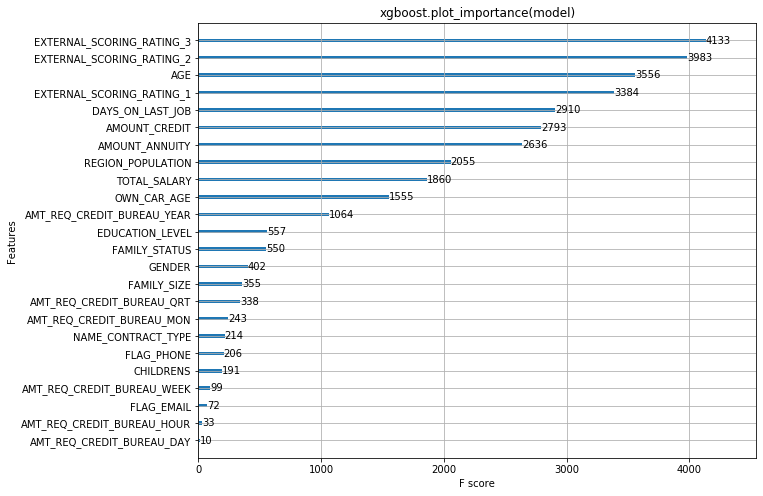

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
xgb.plot_importance(model, ax=ax)
plt.title("xgboost.plot_importance(model)")
plt.show()

Проанализируем полученный результат, возвращаемых `XGBoost`: мы увидим, что возраст является важной характеристикой, а __external_scoring_rating__ преобладают над другими признаками, явно выделяясь как наиболее важные предикторы дефолта. Мы могли бы остановиться на этом и сообщить нашему менеджеру о том, что возраст и внешние данные является наиболее важными характеристиками, и нужно согласовать побольше бюджет на покупку внешних данных :) Но, будучи хорошими специалистами... мы смотрим в документацию `XGBoost` и видим, что есть три варианта измерения важности признаков:

* __Weight__ - сколько раз признак использовался для разбиения вершины дерева, по всем деревьям.

* __Cover__ - количество раз, когда признак используется для разбиения вершины данных, взвешенная на долю наблюдений обучающей выборки, которая проходит через это разбиение. Считается по всем деревьям.

* __Gain__ - среднее снижение значения функции потерь при обучении, полученное при данного признака.


Это типичные меры важности признаков, которые мы можем найти практически в любом пакете моделирования, основанном на деревьях. `Weight` является вариантом по умолчанию, поэтому попробуем два других подхода, чтобы увидеть, имеют ли они отличия.

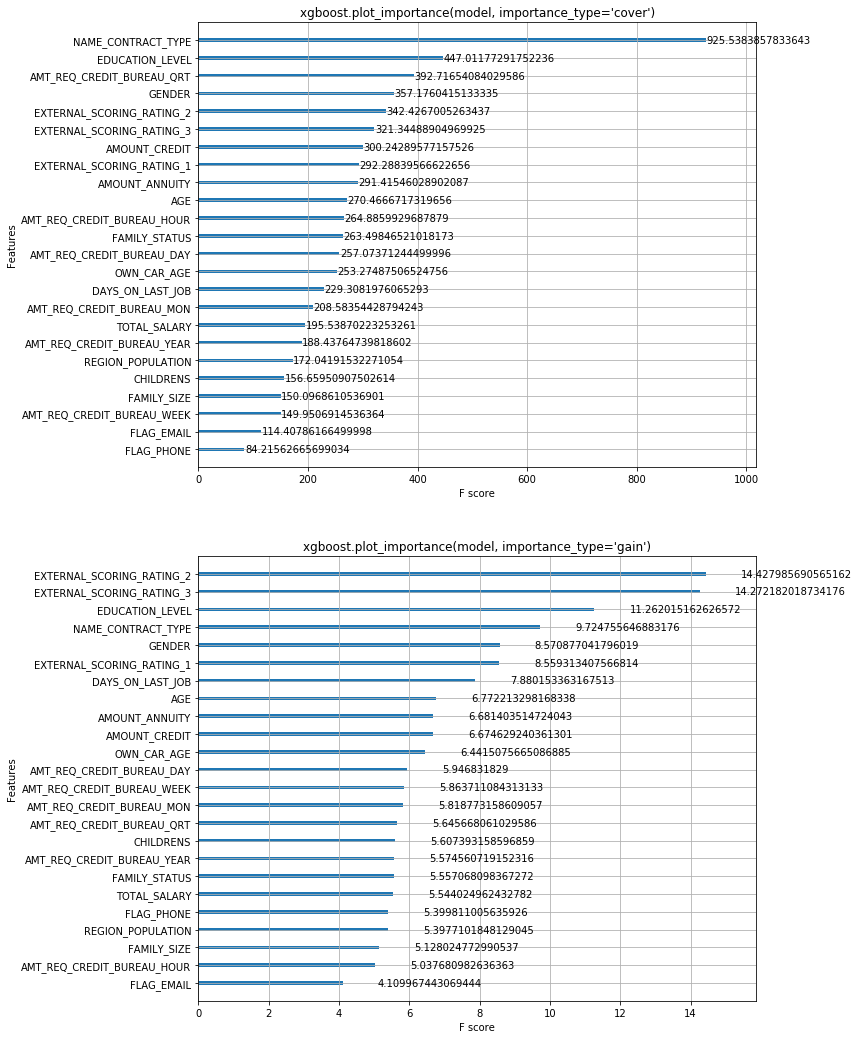

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(10, 18))
xgb.plot_importance(model, ax=ax[0], importance_type="cover")
ax[0].set_title("xgboost.plot_importance(model, importance_type='cover')")

xgb.plot_importance(model, ax=ax[1], importance_type="gain")
ax[1].set_title("xgboost.plot_importance(model, importance_type='gain')")
plt.show()

Странно, мы видим, что список наиболее важных признаков сильно различается для каждого из трех вариантов, предоставляемых `XGBoost`! Для `cover` кажется, что признаки "тип контракта" и "уровень образования" являются самыми важными в задачи кредитного скоринга, в то время как для `gain` признаки, основанные на внешних данных, являются самим важными. Из-за этого нам должно быть очень неудобно полагаться на способы оценки важности признаков, потому что мы не можем выбрать наиболее корректный способ оценки.

## Что делает способ оценки признаков хорошим или плохим?

Определим два свойства, которым должен следовать любой хороший метод оценки важности признаков:

* __Последовательность__ или __консистентность__: каждый раз, когда мы меняем модель так, чтобы она больше полагалась на какой-то фиксированный признак, приписываемая важность этого признака не должна уменьшаться.


* __Точность__: Сумма всех важностей должна составлять общую важность модели. __Например__, если важность измеряется значением $R^2$, то сумма вклада каждого признака должна равняться $R^2$ полной модели.э


Если __точность__ не выполняется, то мы не знаем, как важность каждого конкретного признака объединяется при работе всей модели вцелом. Если __консистентность__ не выполняется, то мы не можем сравнивать важность признаков между любыми двумя моделями, потому что более высокое значение важности не означает, что модель на самом деле больше полагается на это признак. Фактически, если метод неконсистентен, у нас нет гарантии, что признак с максимальной оценкой важности на самом деле является самым важным. Поэтому, давайте проверим консистентность каждого метода, используя две очень простые древовидные модели, не связанные с нашей задачей в курсовом проекте:

<img src="images/web5_2models.png" width=800 height=400 />


Результатом работы моделей является вероятность болезни человека, при наблюдаемых симптомах (высокая температура и кашель). 

__Модель `A`__ - это всего лишь простая функция «и». __Модель `B`__ имеет ту же функцию для получения ответа, но с `+10`, если у пациента наблюдается кашель. Чтобы проверить консистентность, мы должны определить "важность". Здесь мы определим важность двумя способами:

* как изменение ожидаемой качества модели при удалении признака;
* как изменение ожидаемого результата модели при удалении признака.

Первое определение важности измеряет глобальное влияние признака на модель. Второе определение измеряет индивидуальное влияние признака на прогноз на отдельно взятом примере. В нашем примере, признак __кашель__ явно более важен в __модели B__, как для глобального значения, так и для индивидуального прогноза, когда и __температура__, и __кашель положительны__.

Вышеупомянутые методы `weight`, `cover` и `gain` являются способами оценки глобальной важности признаков. Но когда мы развернем нашу модель в продакшене, нам также потребуются индивидуальный вклад каждого признака в прогноз для каждого клиента.

## Почему стандартные подходы не работает - более наглядный пример

In [8]:
feature_a = [
    0, 0, 0, 0, 1, 1, 1, 1
]
feature_b = [
    0, 0, 1, 1, 0, 0, 1, 1
]
feature_y = [
    0, 0, 0, 0, 0, 0, 1, 1
]

df = pd.DataFrame({
    "a": feature_a,
    "b": feature_b,
    "y": feature_y
})

df

,a,b,y
0,0,0,0
1,0,0,0
2,0,1,0
3,0,1,0
4,1,0,0
5,1,0,0
6,1,1,1
7,1,1,1


In [9]:
y_synthetics = df["y"]
X_synthetics = df.drop("y", axis=1)

model_ = xgb.XGBClassifier(max_depth=2, n_estimators=10)
model_.fit(X_synthetics, y_synthetics)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

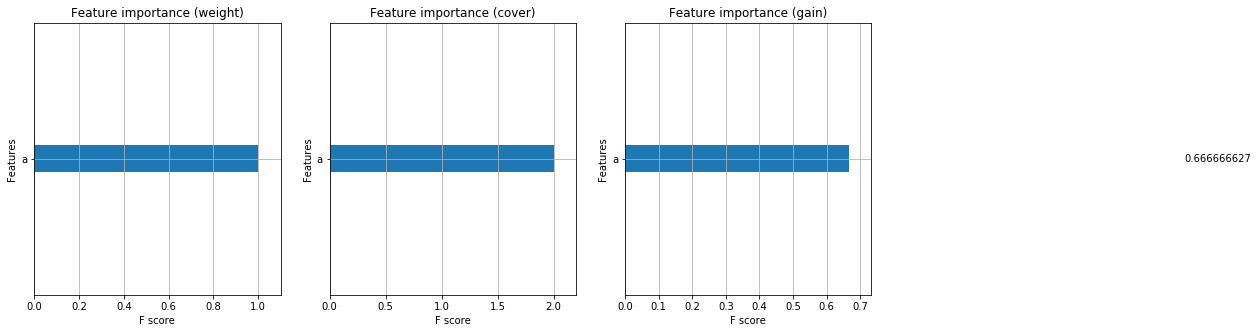

In [10]:
booster = model_.get_booster()
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

xgb.plot_importance(
    booster, ax=axes[0], importance_type="weight", title="Feature importance (weight)"
)
xgb.plot_importance(
    booster, ax=axes[1], importance_type="cover", title="Feature importance (cover)"
)
xgb.plot_importance(
    booster, ax=axes[2], importance_type="gain", title="Feature importance (gain)"
)

## Permutation Importance

__Permutation Importance__ – это метод, широко используемый для вычисления важности признаков. Он помогает нам увидеть, в какой момент модель выдает неожиданные результаты или работает корректно, это способ вычисления важности признаков на основе усредненного уменьшения качества модели.

__Алгоритм вычисления:__

* выбираем метрику для вычислений;
* фиксируем значение метрики на валидационном наборе данных (базовое качество модели);
* для каждого признака делаем:
 * переставляем значения одного признака и применяем модель;
 * оцениваем качество модели с помощью заданной метрики;
 * важность признака оценивается разницей между базовым качество модели (качество на исходном наборе данных) и качеством после пермутации признака; 
 
__Плюсы:__
* гораздо более надежный подход к оценке важности признаков;
* не трубует повторного обучения моделей;
* работает для любой класса моделей машинного обучения;

__Минусы:__
* не позволяет оценить вклад признака в прогнозное значение модели;
* вычислительно сложнее встроенных методов оценки важности признаков;
* потенциальное смещение в пользу коррелирующих между собой признаков.

In [11]:
xgb_params = deepcopy(params)
xgb_params["n_estimators"] = 100

model = xgb.XGBClassifier(**xgb_params)
model.fit(x_train, y_train)

XGBClassifier(base_score=0.08121001324249724, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              eta=0.01, eval_metric='auc', gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.5, verbosity=1)

In [12]:
y_score = model.predict_proba(x_valid)[:, 1]
score = roc_auc_score(y_valid, y_score)

print(f"Valid score = {round(score, 4)}")

Valid score = 0.7468


## sklearn-реализация permutation_importance

In [13]:
from sklearn.inspection import permutation_importance

importance = permutation_importance(
    model, x_valid, y_valid, scoring="roc_auc", n_jobs=6, random_state=27
)

In [16]:
importance_scores = pd.DataFrame({
    "features": x_valid.columns,
    "importance-mean": importance.importances_mean,
    "importance-std": importance.importances_std,
})
importance_scores = importance_scores.sort_values(
    by="importance-mean", ascending=False
)
importance_scores = importance_scores.reset_index(drop=True)
decrease_scores = importance_scores[importance_scores["importance-mean"]<=0]
decrease_scores = decrease_scores.reset_index(drop=True)
decrease_scores

,features,importance-mean,importance-std
0,AMT_REQ_CREDIT_BUREAU_DAY,0.000000,0.000000
1,AMT_REQ_CREDIT_BUREAU_WEEK,0.000000,0.000000
2,CHILDRENS,0.000000,0.000000
3,FLAG_EMAIL,-0.000062,0.000049
4,REGION_POPULATION,-0.000116,0.000169


## eli5-реализация permutation_importance

In [17]:
from eli5.sklearn import PermutationImportance
from eli5 import show_weights

estimator = PermutationImportance(
    model, scoring="roc_auc", random_state=27
)
importance = estimator.fit(x_valid.fillna(-9999), y_valid)

In [18]:
show_weights(importance, feature_names=x_valid.columns.tolist(), top=x_valid.shape[1])

Weight,Feature
0.0758 ± 0.0060,EXTERNAL_SCORING_RATING_3
0.0524 ± 0.0064,EXTERNAL_SCORING_RATING_2
0.0231 ± 0.0064,EXTERNAL_SCORING_RATING_1
0.0050 ± 0.0015,AMOUNT_CREDIT
0.0043 ± 0.0014,EDUCATION_LEVEL
0.0029 ± 0.0012,NAME_CONTRACT_TYPE
0.0029 ± 0.0018,AMOUNT_ANNUITY
0.0015 ± 0.0009,REGION_POPULATION
0.0013 ± 0.0004,GENDER
0.0010 ± 0.0014,DAYS_ON_LAST_JOB


## собственная реализация permutation_importance

In [19]:
def _predict(estimator, x_valid):
    if hasattr(estimator, "predict_proba"):
        y_pred = estimator.predict_proba(x_valid)[:, 1]
    else:
        y_pred = estimator.predict(x_valid)

    return y_pred

def calculate_permutation_importance(estimator,
                                     metric: callable,
                                     x_valid: pd.DataFrame,
                                     y_valid: pd.DataFrame,
                                     maximize: bool = True
                                     ) -> pd.Series:
    """
    Вычисление важности признаков на основе перестановочного
    критерия (permutation importance).

    Parameters
    ----------
    estimator: sklearn-API estimator
        Модель машинного обучения, выполненная в sklearn-API.
        Модель должны быть обученной (применен метод `fit`).

    metric: callable
        Функция для оценки качества прогнозов, функция принимает
        2 аргумента: вектор истинных ответов и вектор прогнозов.

    x_valid: pandas.core.frame.DataFrame
        Матрица признаков для оценки качества модели.

    y_valid: pandas.core.frame.Series
        Вектор целевой переменной для оценки качества модели.

    maximize: bool, optional, default = True
        Флаг максимизации метрики качества.
        Опциональный параметр, по умолчанию, равен `True`.
        Если `True`, значит чем выше значение метрики качества,
        тем лучше. Если `False` - иначе.

    """
    y_pred = _predict(estimator, x_valid)
    base_score = metric(y_valid, y_pred)
    scores, delta = {}, {}

    for feature in tqdm(x_valid.columns):
        x_valid_ = x_valid.copy(deep=True)
        x_valid_[feature] = np.random.permutation(x_valid_[feature])

        y_pred = _predict(estimator, x_valid_)
        feature_score = metric(y_valid, y_pred)

        if maximize:
            delta[feature] = base_score - feature_score
        else:
            delta[feature] = feature_score - base_score

        scores[feature] = feature_score

    scores, delta = pd.Series(scores), pd.Series(delta)
    scores = scores.sort_values(ascending=False)
    delta = delta.sort_values(ascending=False)

    return scores, delta

In [20]:
scores, importance = calculate_permutation_importance(
    estimator, roc_auc_score, x_valid, y_valid
)

100%|██████████| 24/24 [00:02<00:00,  8.72it/s]


In [21]:
importance

EXTERNAL_SCORING_RATING_3     0.070712
EXTERNAL_SCORING_RATING_2     0.054578
EXTERNAL_SCORING_RATING_1     0.021340
DAYS_ON_LAST_JOB              0.008299
EDUCATION_LEVEL               0.005749
AMOUNT_ANNUITY                0.004997
AMOUNT_CREDIT                 0.004956
GENDER                        0.004705
AGE                           0.004559
NAME_CONTRACT_TYPE            0.004370
OWN_CAR_AGE                   0.004279
REGION_POPULATION             0.000953
TOTAL_SALARY                  0.000772
AMT_REQ_CREDIT_BUREAU_YEAR    0.000659
AMT_REQ_CREDIT_BUREAU_QRT     0.000276
AMT_REQ_CREDIT_BUREAU_HOUR    0.000109
AMT_REQ_CREDIT_BUREAU_MON     0.000097
FAMILY_SIZE                   0.000071
FLAG_PHONE                    0.000019
AMT_REQ_CREDIT_BUREAU_DAY     0.000000
AMT_REQ_CREDIT_BUREAU_WEEK    0.000000
CHILDRENS                     0.000000
FLAG_EMAIL                   -0.000049
FAMILY_STATUS                -0.000218
dtype: float64

## Попробуем улучшить модельку на основе permutation-importance

In [22]:
scores, importance = calculate_permutation_importance(
    model, roc_auc_score, x_valid, y_valid
)

100%|██████████| 24/24 [00:02<00:00,  8.99it/s]


In [23]:
to_drop = importance[importance<=0].index.tolist()
dtrain = xgb.DMatrix(x_train.drop(to_drop, axis=1), label=y_train)
dvalid = xgb.DMatrix(x_valid.drop(to_drop, axis=1), label=y_valid)

In [24]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=5000,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=50,
    verbose_eval=100
)

[0]	train-auc:0.723098	valid-auc:0.694538
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[100]	train-auc:0.772448	valid-auc:0.73505
[200]	train-auc:0.786351	valid-auc:0.740399
[300]	train-auc:0.797643	valid-auc:0.743577
[400]	train-auc:0.807621	valid-auc:0.745611
[500]	train-auc:0.816552	valid-auc:0.746773
[600]	train-auc:0.825101	valid-auc:0.747613
[700]	train-auc:0.832809	valid-auc:0.747865
Stopping. Best iteration:
[662]	train-auc:0.830115	valid-auc:0.74798



## SHAP

Фреймворк `SHAP (SHAPley Additive ExPlanations)` является важным достижением в области интерпретации моделей машинного обучения. `SHAP` строит объяснения модели, задавая один и тот же вопрос для каждого прогноза и каждого признака: «Как изменяется прогноз i, когда признак j удаляется из модели?» Так называемые `SHAP-values` - вот ответы. Они количественно определяют величину и направление (положительное или отрицательное) влияния признака на прогноз.

Прежде чем использовать функционал фреймворка, взглянем на значение Шепли, которое является концепцией решения в теории игр.

<img src="images/web5_shap.png" width=500 height=200 />

Возьмем для примера команду разработчиков. __Наша цель__ - разработать модуль, который состоит из 100 строк кода, у нас есть 3 специалиста по данным (L, M, N), которые должны работать вместе, чтобы реализовать проект. При условии, их производительность такова:

<img src="images/web5_shap_table.png" width=200 height=200 />

<img src="images/web5_shap_table2.png" width=700 height=200 />

У нас 3 игрока, итого комбинация их взаимодействия равна `3!` = 6. В приведенных выше таблицах показан вклад в соответствии с различным порядком коалиции.

<img src="images/web5_shap_table3.png" width=700 height=200 />

Таким образом, мы посчитали вклад каждого отдельного сотрудника в итоговый проект. Хотя возможности сотрудника `M` в 6 раз больше, чем сотрудника `N` (30 против 5), `M` должен получить 41,7% вознаграждения, а `N` должен получить 24,17% вознаграждения. Таким образом, для построения значений Шепли, мы используем теорию игр, которая делает ряд предположений:

* сумма вознаграждений каждого игрока равна общей сумме призового фонда;
* если два игрока сделали одинаковый вклад в игру, их вознаграждение одинаково;
* если игрок сделал нулевой вклад в игру, то его вознаграждение равно нулю;
* если игрок провел несколько игр, то его суммарное вознаграждение состоит из суммы вознаграждений за каждую игру.

## Интерпретация прогнозов

Используем реализацию `Tree SHAP`, интегрированную в `XGBoost`, чтобы понять вклад каждого признака в итоговый прогноз на отдельных объектах;

In [25]:
model = xgb.XGBClassifier(**params)
model.fit(x_train, y_train)

XGBClassifier(base_score=0.08121001324249724, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              eta=0.01, eval_metric='auc', gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.5, verbosity=1)

In [26]:
x_valid_, y_valid_ = x_valid.sample(2000), y_valid.sample(2000)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid_, y_valid_)

In [27]:
shap.force_plot(
    explainer.expected_value, shap_values[0,:], x_valid_.iloc[0,:], link="logit"
)

## Гистограмма важности признаков

Берется среднее значение величин `SHAP` по всему набору данных и отображает его в виде простой столбчатой диаграммы.

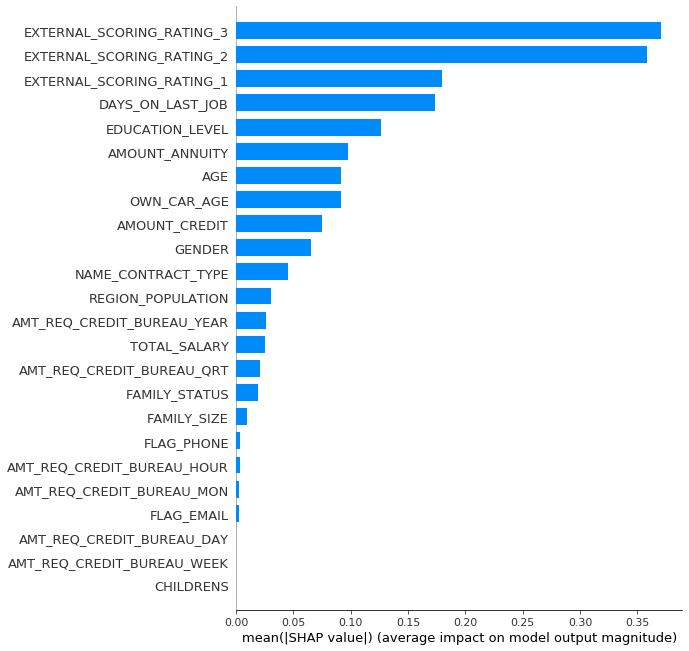

In [28]:
shap.summary_plot(shap_values, x_valid_, plot_type="bar", max_display=x_valid_.shape[1])

## SHAP Summary Plot

Вместо того, чтобы использовать типичную гистограмму важности функций, мы используем диаграмму разброса плотности значений `SHAP` для каждого признака, чтобы определить, какое влияние каждый признак оказывает на выходные данные модели для отдельных наблюдений в валидационном наборе данных. Признаки сортируются по сумме величины SHAP-значений для всех объектов исследуемой выборки. Обратим внимание, что когда точки не помещаются на одной линии, они накапливаются, чтобы показать плотность, а цвет каждой точки представляет значение признака.

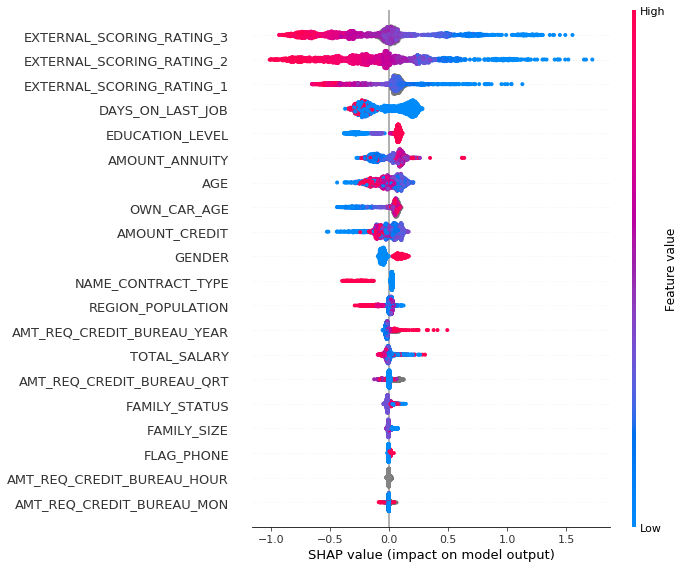

In [29]:
shap.summary_plot(shap_values, x_valid_)

## SHAP Dependence Plots

`SHAP Dependence Plots` показывают влияние одного признака на весь набор данных. Они отображают значение функции по сравнению с SHAP-значениями этого признака на многих наблюдениях. `SHAP Dependence Plots` учитывают эффекты взаимодействия, присутствующие в признаках, и определяются только в областях входного пространства, поддерживаемых данными. Вертикальный разброс SHAP-values для одного признака определяется эффектами взаимодействия, и для выделения возможных взаимодействий выбирается другой признак.

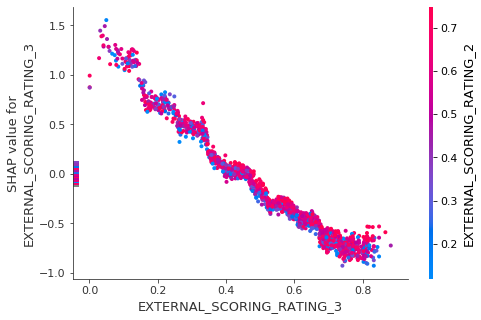

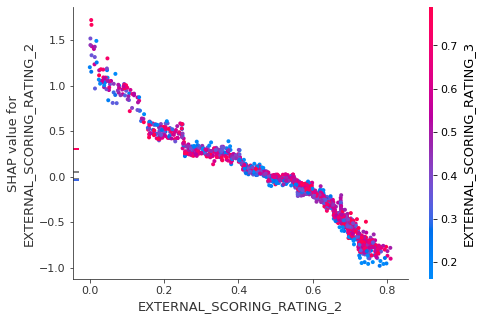

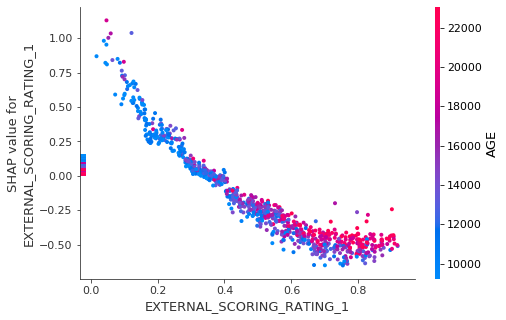

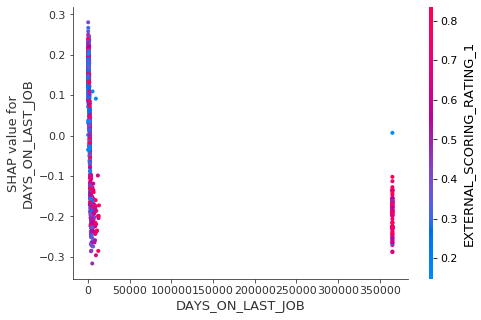

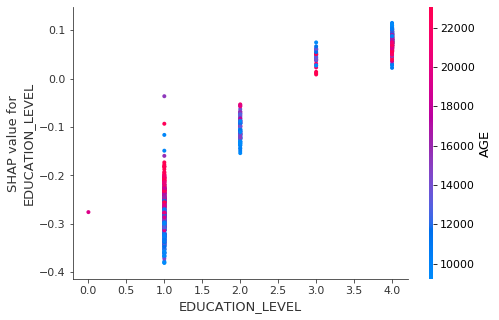

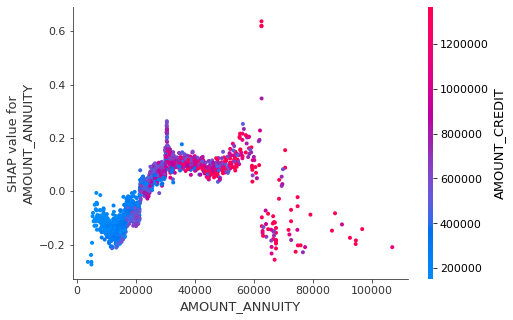

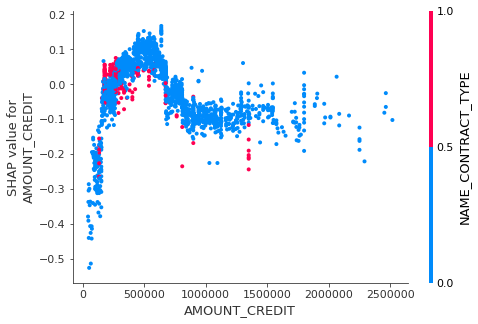

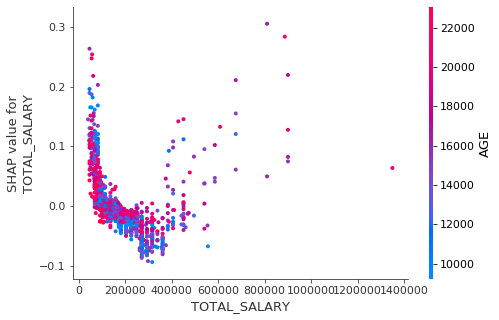

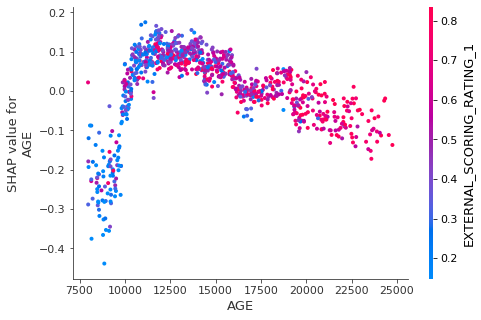

In [30]:
dependence_features = [
    "EXTERNAL_SCORING_RATING_3",
    "EXTERNAL_SCORING_RATING_2",
    "EXTERNAL_SCORING_RATING_1",
    "DAYS_ON_LAST_JOB",
    "EDUCATION_LEVEL",
    "AMOUNT_ANNUITY",
    "AMOUNT_CREDIT",
    "TOTAL_SALARY",
    "AGE",
]
for name in dependence_features:
    shap.dependence_plot(name, shap_values, x_valid_, display_features=x_valid_)

## Basic decision plot features

* ось __`x`__ представляет результат работы модели. В этом случае единицы являются `log-odds`.


* ось __`y`__ показывает признаки модели. По умолчанию, признаки упорядочены по убыванию важности. Важность рассчитывается по нанесенным на график наблюдениям. Обычно, такой расчет отличается от порядка важности признаков для всего набора данных.


* Прогноз каждого наблюдения представлен цветной линией. Вверху графика каждая линия пересекает ось абсцисс на уровне предсказанного значения соответствующего наблюдения. Это значение определяет цвет линии на спектре.


* При перемещении снизу графика вверх, значения SHAP для каждого объекта добавляются к базовому значению модели. Это показывает, как каждый признак способствует общему прогнозу.

In [31]:
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = x_valid.iloc[select]
features_display = x_valid.loc[features.index]
shap_values = explainer.shap_values(features)
shap_interaction_values = explainer.shap_interaction_values(features)

if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

Explainer expected value: -2.4512915383547806


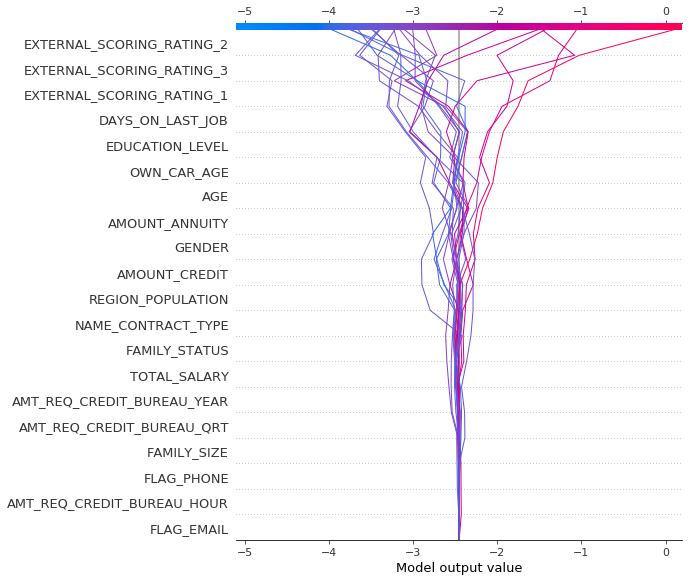

In [32]:
shap.decision_plot(
    expected_value, shap_values, features_display.iloc[:20]
)

График поддерживает `link = 'logit' `для преобразования логарифмических шансов в вероятности.

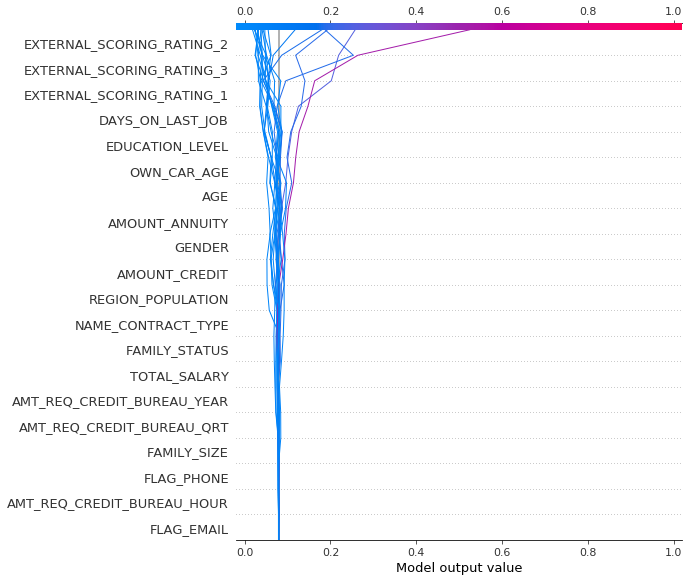

In [33]:
shap.decision_plot(expected_value, shap_values, features_display.iloc[:20], link="logit")

Наблюдения можно выделить с помощью пунктирной линии. Выделим неверно классифицированное наблюдение.

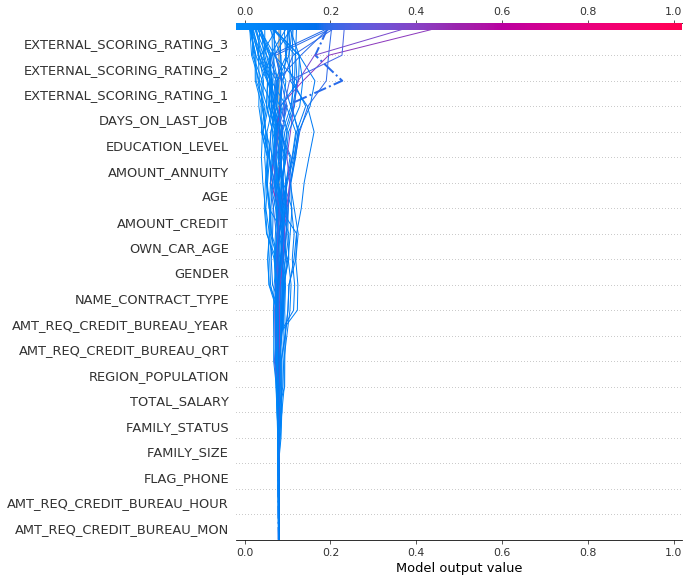

In [40]:
shap_values = explainer.shap_values(x_valid_, y_valid_)
y_pred = (shap_values.sum(1) + expected_value) > 0

misclassified = y_pred != y_valid_
shap.decision_plot(
    expected_value, shap_values[200:250], features_display.iloc[200:250],
    link='logit', highlight=misclassified[200:250]
)

Давайте проверим ошибочно классифицированное наблюдение, построив его отдельно. Когда построено отдельное наблюдение, отображаются соответствующие значения признаков. Обратите внимание, что форма линии изменилась. Почему? Порядок объектов по оси __$Y$__ изменился в зависимости от важности признаков для этого одиночного наблюдения.

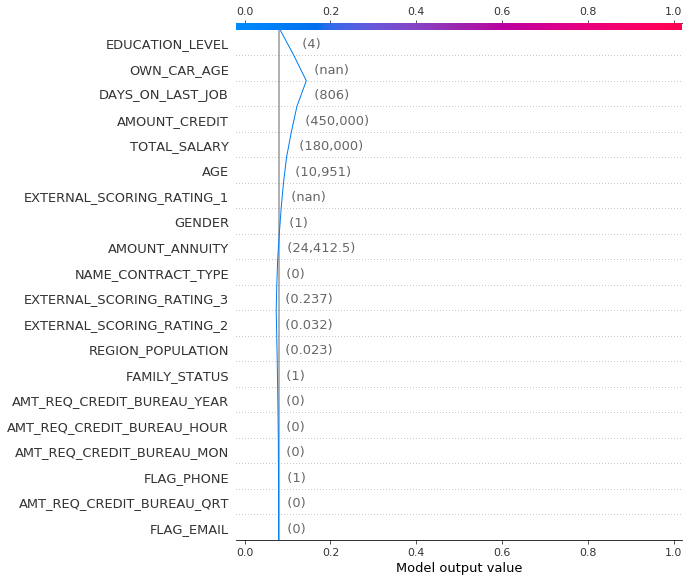

In [41]:
shap.decision_plot(
    expected_value, shap_values[15], features_display.iloc[15], link='logit', highlight=misclassified.iloc[15]
)

`Force-plot` для ошибочно классифицированного наблюдения показан ниже. В этом случае `Force-plot` эффективен для демонстрации того, как модель пришла к своему решению, то есть для визуализации и понимания ошибок модели.

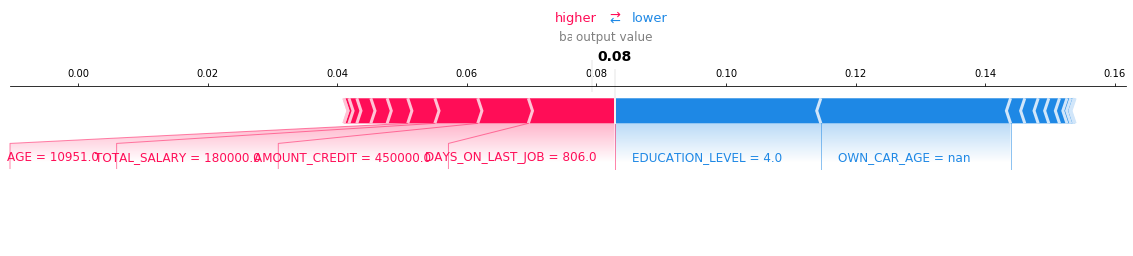

In [42]:
shap.force_plot(
    expected_value,
    shap_values[15],
    features_display.iloc[15],
    matplotlib=True,
    link='logit'
)

## Выделение аномалий

`decision_plot` могут помочь выявить выбросы, укажем `feature_order = 'hclust'`, чтобы сгруппировать наблюдения с похожими путями прогнозирования. Это часто упрощает выявление выбросов. Не будем использования `link = 'logit'` при построении выбросов, потому что предсказания амплитуды искажаются сигмоидой.

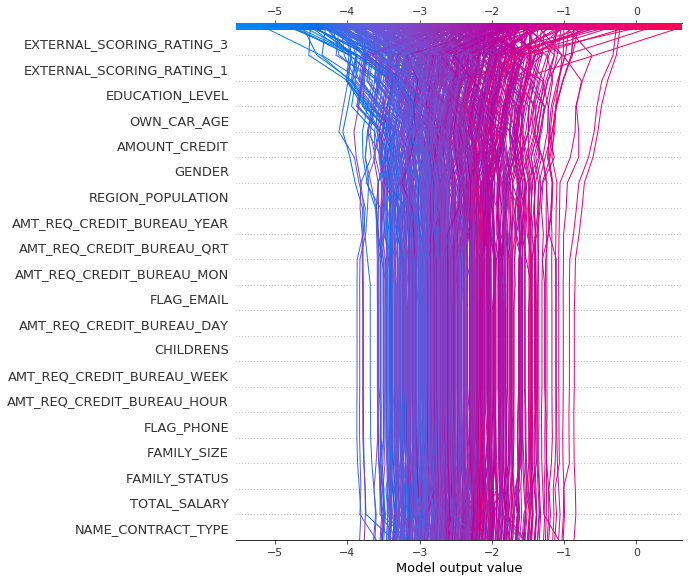

In [43]:
y_pred = model.predict_proba(x_valid)
T = x_valid[(y_pred >= 0.5) & (y_pred <= 1)]
T = T.sample(500)

sh = explainer.shap_values(T)
r = shap.decision_plot(expected_value, sh, T, feature_order='hclust', return_objects=True)